12:48:13 - cmdstanpy - INFO - Chain [1] start processing
12:48:14 - cmdstanpy - INFO - Chain [1] done processing


Model saved as 'prophetic_model.pkl'
Monthly forecast results saved to 'prophet_monthly_forecast.csv'


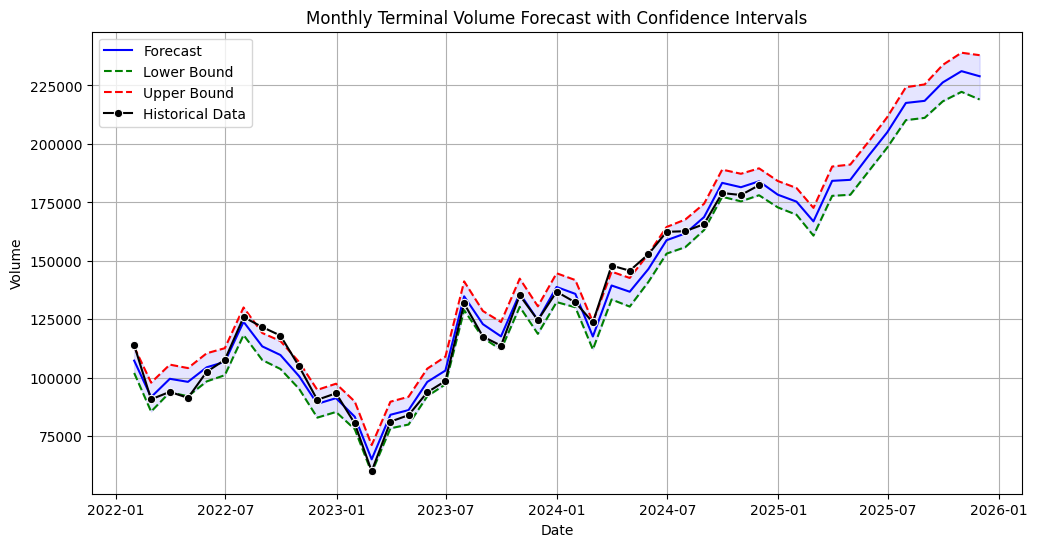

In [24]:
# Importing necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
import pickle
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import seaborn as sns

# Step 1: Load and Prepare Data (Aggregating to Monthly)
df = pd.read_csv('mps_volumes.csv')  # Load the data
df.columns = ['ds', 'y']  # Renaming the columns
df['ds'] = pd.to_datetime(df['ds'])  # Ensure 'ds' is datetime

# Resample the data to monthly frequency
df_monthly = df.resample('M', on='ds').sum().reset_index()

# Save the resampled data for reference
df_monthly.to_csv('historical.csv', index=False)

# Step 2: Define Crisis Event (Assuming crisis is still on a daily level)
v_crisis = pd.DataFrame({
    'holiday': 'crisis',
    'ds': pd.date_range(start='2022-10-01', end='2023-03-01', freq='D'),  # Use daily crisis
    'lower_window': 0,
    'upper_window': 0
})

# Step 3: Initialize and Fit the Prophet Model
model = Prophet(yearly_seasonality=True, holidays=v_crisis)

# Fit the model on the training data
model.fit(df_monthly)

# Step 4: Save the Trained Model
with open('prophetic_model.pkl', 'wb') as model_file:
    pickle.dump(model, model_file)
print("Model saved as 'prophetic_model.pkl'")


# Step 5: Make Monthly Predictions and Visualize
future = model.make_future_dataframe(periods=12, freq='M')  # Predict for the next 12 months
forecast = model.predict(future)


# Save forecast results
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].to_csv('prophet_monthly_forecast.csv', index=False)
print("Monthly forecast results saved to 'prophet_monthly_forecast.csv'")

# Step 6: Visualize the Monthly Forecast with Confidence Intervals
plt.figure(figsize=(12, 6))
sns.lineplot(data=forecast, x='ds', y='yhat', label='Forecast', color='blue')
sns.lineplot(data=forecast, x='ds', y='yhat_lower', label='Lower Bound', linestyle='--', color='green')
sns.lineplot(data=forecast, x='ds', y='yhat_upper', label='Upper Bound', linestyle='--', color='red')
sns.lineplot(data=df_monthly, x='ds', y='y', label='Historical Data', color='black', marker='o')
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='blue', alpha=0.1)
plt.title('Monthly Terminal Volume Forecast with Confidence Intervals')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.grid(True)
plt.show()
